In [28]:
import requests

def fetch_crypto_data():
    url = 'https://min-api.cryptocompare.com/data/v2/histohour'
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 1000,   # Number of data points
        'aggregate': 1,  # Hourly data
    }
    response = requests.get(url, params=params)
    data = response.json()['Data']['Data']  # Extracting the historical data
    return data

# Example usage:
crypto_data = fetch_crypto_data()
print(crypto_data)


[{'time': 1715270400, 'high': 62669.45, 'low': 61818.06, 'open': 62143.8, 'volumefrom': 2060.69, 'volumeto': 128442444.21, 'close': 61862.48, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1715274000, 'high': 62199.03, 'low': 61749.74, 'open': 61862.48, 'volumefrom': 824.57, 'volumeto': 51111299.3, 'close': 61945.47, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1715277600, 'high': 62251.1, 'low': 61884.75, 'open': 61945.47, 'volumefrom': 675, 'volumeto': 41923285.34, 'close': 62249.89, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1715281200, 'high': 62548.13, 'low': 62174.63, 'open': 62249.89, 'volumefrom': 1092.63, 'volumeto': 68124943.36, 'close': 62453.83, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1715284800, 'high': 62655.24, 'low': 62351.55, 'open': 62453.83, 'volumefrom': 634.2, 'volumeto': 39641732.87, 'close': 62632.43, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1715288400, 'high': 62820.49,

In [29]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(data):
    # Ensure data is correctly structured
    if not isinstance(data, list) or not isinstance(data[0], dict):
        raise ValueError("Input data must be a list of dictionaries")

    # Extract closing prices
    prices = [entry['close'] for entry in data]

    # Normalize data using Min-Max scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    prices_normalized = scaler.fit_transform(np.array(prices).reshape(-1, 1))

    # Prepare sequences for LSTM (assume window size of 10 for demonstration)
    window_size = 10
    X, y = [], []
    for i in range(len(prices_normalized) - window_size):
        X.append(prices_normalized[i:i + window_size, 0])
        y.append(prices_normalized[i + window_size, 0])
    X, y = np.array(X), np.array(y)

    # Reshape X for LSTM (samples, time steps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

X, y, scaler = preprocess_data(crypto_data)


In [30]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

#LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=input_shape))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


input_shape = (X.shape[1], 1)  # (time steps, features)
model = build_lstm_model(input_shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)



Epoch 1/10


c:\Users\adria\Documents\GitHub\Predicting-BTC-USD-Prices-Using-MLOps-on-AWS\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2157
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023


In [31]:
#last_sequence = X[-window_size:]  # Take the last window_size data points
    
#last_sequence.shape

In [32]:
import numpy as np

# Function to make predictions using the LSTM model
def make_predictions(model, data, scaler, window_size, num_predictions):
    predictions = []
    
    # Extract the last window_size data points from the original data (not from X)
    last_sequence = data[-window_size:]
    
    # Normalize the last_sequence using the same scaler
    last_sequence = scaler.transform(last_sequence.reshape(-1, 1))
    
    if last_sequence.shape != (window_size, 1):
        raise ValueError(f"Expected last_sequence to have shape ({window_size}, 1), but got {last_sequence.shape}")

    # Reshape last_sequence to match model input shape (samples, time steps, features)
    last_sequence = np.reshape(last_sequence, (1, window_size, 1))
    
    for _ in range(num_predictions):
        # Predict next value
        prediction = model.predict(last_sequence)[0, 0]

        # Append prediction to results
        predictions.append(prediction)

        # Update last_sequence to include the new prediction and drop the oldest value
        last_sequence = np.append(last_sequence[:, 1:, :], [[[prediction]]], axis=1)

    # Inverse transform predictions to get actual values
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions.flatten()

# Example usage
# Assuming you have defined and trained your LSTM model and have loaded `X`, `y`, `scaler`, and `window_size`

window_size=10
# Generate predictions for the next 10 hours
num_predictions = 10
predictions = make_predictions(model, y, scaler, window_size, num_predictions)

# Print the predictions
print(f'Predictions for next {num_predictions} hours: {predictions}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predictions for next 10 hours: [50177.13  48804.234 48572.348 48745.906 49201.26  49835.816 50580.723
 51399.78  52285.48  53260.668]


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#make predictions on x
y_pred= model.predict(X)
# Inverse transform the predictions and the actual values to get them back to original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ValueError: Found input variables with inconsistent numbers of samples: [199, 991]

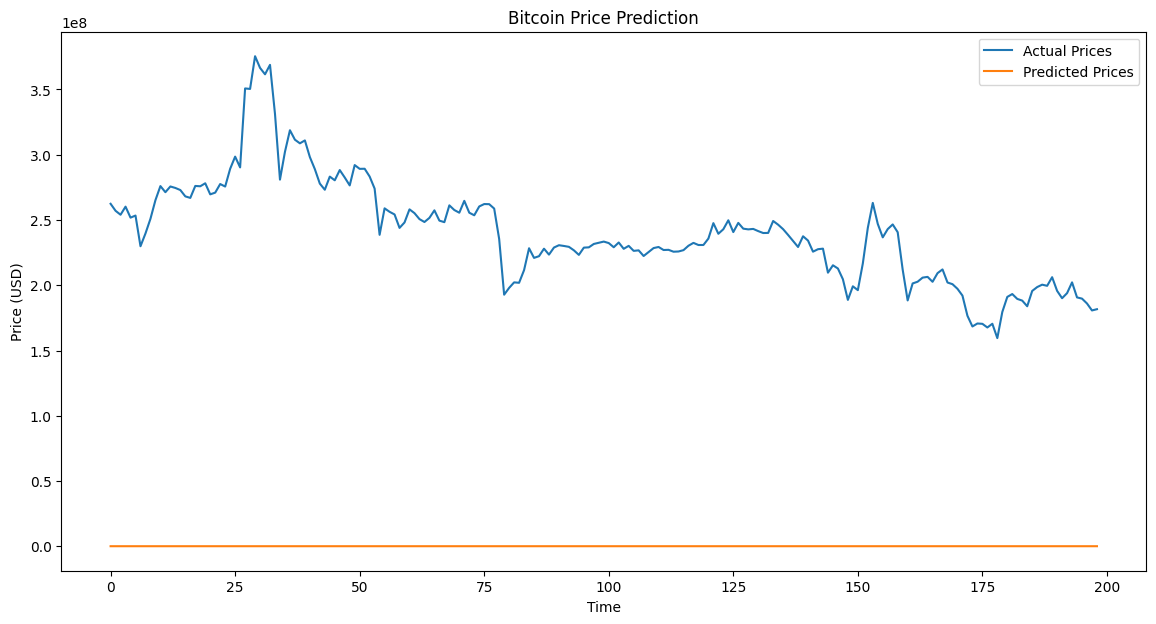

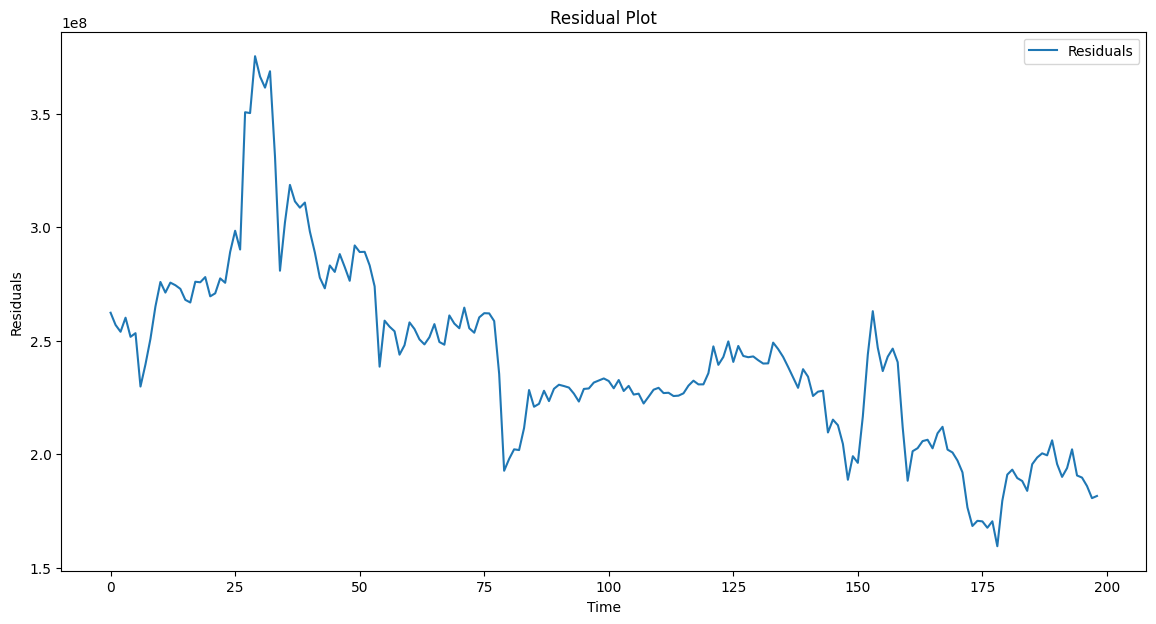

In [ ]:
# Visual inspection
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse[:, 0], label='Actual Prices')
plt.plot(y_test_pred_inverse[:, 0], label='Predicted Prices')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot residuals
residuals = y_test_inverse[:, 0] - y_test_pred_inverse[:, 0]
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals')
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.layers import GRU

def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, input_shape=input_shape))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_model = build_gru_model(input_shape)
gru_history = gru_model.fit(X, y, epochs=10, batch_size=32, verbose=1)
gru_predictions = make_predictions(gru_model, y, scaler, window_size, num_predictions)
print(f'GRU Predictions for next {num_predictions} hours: {gru_predictions}')


In [ ]:
import pmdarima as pm

def arima_model(data, num_predictions):
    model = pm.auto_arima(data, seasonal=False, stepwise=True)
    forecast = model.predict(n_periods=num_predictions)
    return forecast

arima_predictions = arima_model([entry['close'] for entry in crypto_data], num_predictions)
print(f'ARIMA Predictions for next {num_predictions} hours: {arima_predictions}')


In [ ]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

def build_transformer_model(input_shape, num_heads=2, ff_dim=32):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output)
    attn_output = Dropout(0.1)(attn_output)
    
    ffn_output = Dense(ff_dim, activation='relu')(attn_output)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    
    outputs = Dense(1)(ffn_output)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

transformer_model = build_transformer_model(input_shape)
transformer_history = transformer_model.fit(X, y, epochs=10, batch_size=32, verbose=1)
transformer_predictions = make_predictions(transformer_model, y, scaler, window_size, num_predictions)
print(f'Transformer Predictions for next {num_predictions} hours: {transformer_predictions}')


In [ ]:
import xgboost as xgb

def build_xgboost_model(X, y):
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X.reshape(X.shape[0], -1), y)
    return model

xgb_model = build_xgboost_model(X, y)
xgb_predictions = xgb_model.predict(X[-window_size:])
xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))
print(f'XGBoost Predictions for next {num_predictions} hours: {xgb_predictions}')
